In [ ]:
# default_exp data.core_pd

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [ ]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [ ]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [ ]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [ ]:
# export

class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = {}, {}

    def encodes(self, o):
        for i in range(len(o)-1):
            if type(o[i]) == TensorCon and o[i].shape[-1]>0:
                self.m[i] = torch.mean(o[i])
                self.s[i] = torch.std(o[i]) +self.eps
            elif type(o[i]) == TensorSeqs :
                self.m[i] = torch.mean(o[i], -1, keepdim=True)
                self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            else:
                print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                self.m[i], self.s[i] = 0, 1
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0]         
            
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
            
        return MetaTuple([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])              

    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return MetaTuple([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

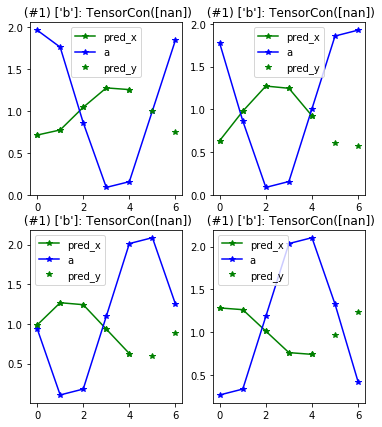

In [ ]:
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        test_close(a.mean(),0)
        test_close(a.std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),MetaTuple)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),MetaTuple)

dl.show_batch(max_n = 4)

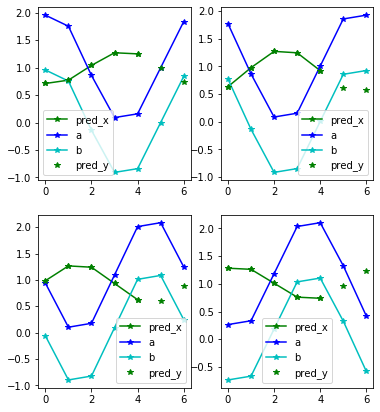

In [ ]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[a for _ in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        for i in range(a.shape[0]):
            test_close(a[i].mean(),0)
            test_close(a[i].std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),MetaTuple)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),MetaTuple)

dl.show_batch(max_n = 4)

# TSDataLoaders

## Utils

In [ ]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [ ]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [ ]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [ ]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

,x,weather,city,cont
0,"[1.4335600618509872, 1.4749606809876075, 1.3274833553969565, 1.313361860970899, 1.0634347442329195, 1.2166221220593738, 1.2619455236167216, 1.2071775260392574, 1.226090034346909, 1.1568814548860105, 0.8492217745792289, 0.9061209811423108, 0.6949629818108812, 0.7483584821987755, 0.6682785893284182, 0.6815364631750012, 0.8736978904068456, 0.916154063571707, 1.1474676420226921, 1.171400383993689, 1.0005385788449097, 1.1095576768022504, 0.9468115097040701, 0.8665441124831089, 0.7341622172603793, 0.5934312051959999, 0.6657470108606647, 0.5939050564529069, 0.4894058465764546, 0.4763326131493753,...","[9.637265149396429, 9.426774142980143, 9.393632066279277, 9.577752492164903, 9.941495340322431, 10.375801549628955, 10.730330924073582, 10.858886814973548, 10.666430658876656, 10.143125210995336, 9.37440905584592, 8.52307269508593, 7.787619701523189, 7.348374788643511, 7.31668373877141, 7.701945934536935, 8.406266114791517, 9.248639434129997, 10.012096868056421, 10.500629994811945, 10.589927959479263, 10.257809976337597, 9.58616979592257, 8.73450668482862, 7.893263760258794, 7.2308377213699595, 6.849628193120843, 6.763462153284564, 6.902111480374725, 7.14043073728817, 7.342341679059284, 7....",0,0.450363
1,"[-2.35293568722802, -2.3333275084412155, -2.084549574429389, -1.9196649057568185, -1.7745062383874386, -1.674892358168949, -1.5080601475136959, -1.2009845121885085, -1.2952139063991532, -1.0841620207199316, -0.8472038049965585, -0.9955068314234856, -0.7819919096687119, -0.8462061611408868, -0.512003962921699, -0.2972869545718761, 0.0425974003872552, 0.21503622389156649, 0.560587814301706, 0.7668622652115675, 0.9468694926355495, 0.8979048094472478, 1.1483249533460864, 1.115251997987079, 0.9657340178972942, 0.9757829164877747, 1.036550523763732, 0.9731686038626561, 0.9581872368119244, 0.8012...","[7.290046599011071, 7.187729904436577, 7.195131010446044, 7.379538267602695, 7.739896979337074, 8.202235646603436, 8.639632537470574, 8.911041640263136, 8.907243584544926, 8.589662669706277, 8.009604614935531, 7.301121466068136, 6.648535988927905, 6.237323534008054, 6.202248347712808, 6.587797374749346, 7.332660737714282, 8.283208368894556, 9.232589156571793, 9.97467676620957, 10.357785565198503, 10.3231493840726, 9.917574411290351, 9.27714144936651, 8.58714297849671, 8.030156504821807, 7.737320109122654, 7.756593634500304, 8.04648741529048, 8.496036821374032, 8.964012970777919, 9.32481068...",0,0.523083
2,"[1.0246943372796624, 1.130364725825462, 0.8566592344467319, 1.2064149323160551, 1.0360414141249235, 0.7032548673708358, 0.6361458998337802, 1.0130062927500678, 0.7198519522538048, 0.8070216124564018, 0.98527515104312, 0.7122019624571619, 1.2462020082225658, 1.0976588573797066, 1.4390707727580894, 0.9715681035675191, 1.2734257528407185, 1.073965166153, 1.039833559397705, 0.7279949568796562, 0.6076312449315886, 0.704060496356128, 0.22896946304685042, 0.05136571945985395, -0.20465502884312076, -0.16229032720676215, -0.23615333635945468, -0.28110515754809007, -0.9012904897209061, -0.6752348553...","[7.582181040570933, 7.4969385366272965, 7.41336749688059, 7.3453233872341475, 7.310705951995028, 7.32533000774834, 7.397150812578121, 7.522609207732132, 7.686234709462932, 7.8636752755877595, 8.027300777318553, 8.152759172472564, 8.224579977302344, 8.239204033055675, 8.204586597816537, 8.136542488170091, 8.052971448423396, 7.9677289444797585, 7.886004603643038, 7.802608798609385, 7.7036860634754705, 7.571336653934235, 7.389745753400579, 7.150958103790461, 6.858532863856069, 6.527940517344901, 6.183533106439746, 5.8529407599286, 5.5605155199941985, 5.321727870384054, 5.140136969850392, 5.00...",0,-0.017250
3,"[-2.2794190594180535, -2.1799611027679333, -2.02070140822269, -1.9170635498697197, -1.7972881231672395, -1.6630018979128467, -1.5531598528057216, -1.3863305890574038, -1.2218168721267264, -1.061105435975366, -0.9196585368510876, -0.7711600535195391, -0.6855355279956356, -0.551302014779488, -0.5677926477095726, -0.425946681

In [ ]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [ ]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [ ]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            make_ones = kwargs.pop('make_ones', True)
            kwargs.update({'after_batch':L(NormalizeTSMulti(make_ones=make_ones))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [ ]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [ ]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [ ]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [ ]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [ ]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [ ]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df['city'] = df['city'].astype(float)
df.head(3)

,x,weather,city,cont
0,"[[-2.5697924763451585, -2.350986306284576, -2.2957487582868894, -2.116559935322432, -1.885930287619068, -1.7522982247656018, -1.5845382727495307, -1.4379609381994827, -1.1861282830563995, -1.0248553834765526, -0.7775889328449122, -0.5297164012868172, -0.39386462262215916, -0.20228880267308477, -0.027907550494484425, 0.08387119229017694, 0.1750518676830162, 0.16554266149113628, 0.22077105079546308, 0.12462257757495568, 0.10867363641255576, -0.0038361711958627377, -0.06495587670060586, -0.04365214822508917, -0.16650221812336916, -0.26346252050343993, -0.2948931423026896, -0.31744177508024735...","[[6.7888406663278005, 6.483062806696905, 6.19277141876263, 5.960684045023152, 5.820999486357645, 5.794159331189473, 5.883510982972544, 6.074342485203714, 6.33543696884272, 6.622951513119439, 6.886108039334162, 7.073935494710446, 7.142156696255065, 7.059289628737393, 6.811135047907868, 6.403036283979268, 5.859594396009528, 5.221862272439919, 4.5423790375289546, 3.878695683365682, 3.2862451680237306, 2.8114980269618033, 2.486306002983448, 2.3241765146012434, 2.318961493922062, 2.446120201111392, 2.66637073762784, 2.931225619881719, 3.1896559596187, 3.394980277297368, 3.5110476755042352, 3.51...",0.0,0.087626
1,"[[-2.347359087873518, -2.1920355366514648, -1.9414147972535891, -1.5662141763748445, -1.496551454368077, -1.2829988114906983, -1.1153955963123279, -0.9617254674455943, -0.6874795857562265, -0.5748363767166865, -0.4974516279046429, -0.4067714913009123, -0.3949092507181058, -0.3708776616321693, -0.28990789101990155, -0.11262781927953448, -0.03681060433357105, 0.35764264281890695, 0.7361154761928512, 0.9920085116859072, 1.2838653089733763, 1.3401488843868479, 1.3121312977650534, 1.1621954516002295, 1.171287075109488, 0.9669187708507441, 0.8226503856011186, 0.5792477042968606, 0.62689731896261...","[[4.489531089430493, 4.280605390056504, 3.889587405947813, 3.5197915756004656, 3.351195878901104, 3.4817834123511164, 3.896195343649749, 4.471379359045836, 5.017429759245309, 5.340881854653052, 5.310672255799933, 4.905964019536059, 4.230393582827321, 3.487429994091096, 2.9234003993621025, 2.7547463388945914, 3.1011906117414787, 3.9451292381222465, 5.130071805836308, 6.399531280829464, 7.465795942559867, 8.089066945105076, 8.144195881376547, 7.655700654258604, 6.790880046022659, 5.812997891667411, 5.0080812609593455, 4.606459105656669, 4.721530749080635, 5.323017889970048, 6.251697948427617...",0.0,-0.373670
2,"[[2.3004066802303864, 2.124231976753159, 1.8354166640028888, 1.6838561055205303, 1.551277612464806, 1.4886719343036634, 1.4271872665178353, 1.3085064137052493, 1.0726371893612778, 0.5638090350393418, 0.21103207003723595, 0.1279389004482136, -0.0175275779409252, -0.1897650322149039, -0.12350817877333578, 0.3210831087629891, 0.07507111926613545, 0.524340113260052, 0.7958943084849112, 0.8503286588644026, 1.0516168912914108, 0.8872155764453274, 0.9005231523980513, 0.6508125191439142, 0.9160112877778391, 0.34305436524120425, 0.7617945477981626, 0.7439953721388324, 0.7883867759638922, 0.69974019...","[[4.814768806980126, 4.627751125298087, 4.68622070884766, 4.991681824297281, 5.455621982598313, 5.92120003790646, 6.208122158651868, 6.167559848983018, 5.730551444179554, 4.934890052166203, 3.92162164831023, 2.9011670869814243, 2.098106839719464, 1.6901337728414068, 1.7586400331128198, 2.2652429184423535, 3.061174758947344, 3.927021403020074, 4.6315663909200175, 4.9930487361328995, 4.925566889943958, 4.457812475366543, 3.7194613276576467, 2.899966348970661, 2.192402503677417, 1.7390895922029255, 1.5947968867935598, 1.717743974371609, 1.9900723807383742, 2.260559770058805, 2.395759744536059...",0.0,0.372362


Train:260; Valid: 110; Test 10


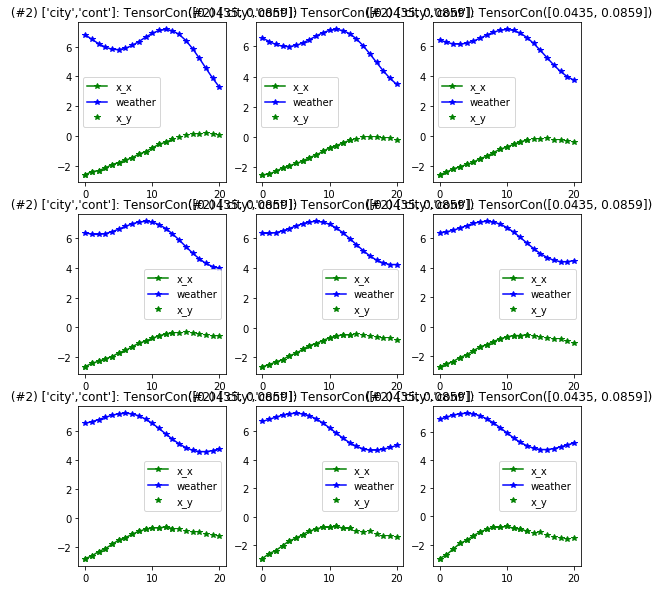

In [ ]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=14, step=2, bs=32)
dbunch.train.show_batch(max_n=9)

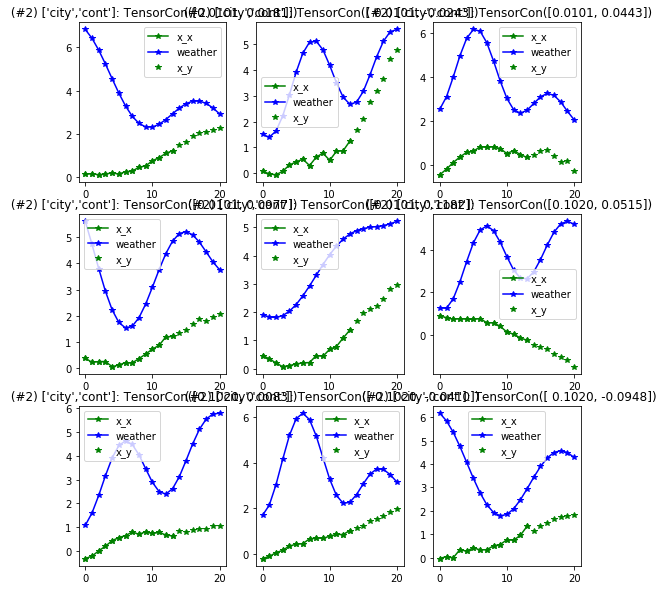

In [ ]:
dbunch.test.show_batch(max_n=9)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
